## EXOD Detector MOS

Import

In [1]:
import sys
import os
import time
import shutil
from functools import partial
from datetime import datetime, date

# Third-party imports

from math import *
from multiprocessing import Pool
from astropy.io import fits
from astropy.table import Table, Column
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import argparse
import matplotlib
matplotlib.use("Pdf")
from matplotlib import colors, image, transforms, gridspec
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from pylab import figure, cm

# Internal imports

from fits_extractor import *
from variability_utils import *
import file_names as FileNames
from file_utils import *
from renderer import *
from exodus_utils import *

Arguments

In [75]:
path = '/home/monrillo/data/0112570101/'
evts = path + 'PN_clean.fits'
img  = path + 'PN_image.fits'
gti  = path + 'PN_gti.fits'
out  = path + '10_100_5_1.0_PN/'
obs  = '0112570101'
bs   = 5
dl   = 10
tw   = 100
gtr  = 1.0
mta  = 8
inst = 'PN'
ol   = path + 'log.txt'
ccdnb = 12

In [40]:
path = '/home/monrillo/data/0112570101/'
evts = path + 'M1_clean.fits'
img  = path + 'M1_image.fits'
gti  = path + 'M1_gti.fits'
out  = path + '8_300_5_1.0_M1/'
obs  = '0112570101'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0
mta  = 8
inst = 'M1'
ol   = path + 'log.txt'
ccdnb = 7

In [50]:
path = '/home/monrillo/data/0112570101/'
evts = path + 'M2_clean.fits'
img  = path + 'M2_image.fits'
gti  = path + 'M2_gti.fits'
out  = path + '8_300_5_1.0_M2/'
obs  = '0112570101'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0
mta  = 8
inst = 'M2'
ol   = path + 'log.txt'
ccdnb = 7

Preliminaries

In [105]:
# Opening the output fileslog_f, var_f, reg_f = open_files(out)
log_f, var_f, reg_f = open_files(out)
sys.stdout = Tee(sys.stdout, log_f)

# Recovering the EVENTS list
data, header = extraction_photons(evts)

# Recovering the GTI list
gti_list = extraction_deleted_periods(gti)

# Computation of t0 and tf
t0_observation = min([evt['TIME'] for ccd in data for evt in ccd])
tf_observation = max([evt['TIME'] for ccd in data for evt in ccd])

In [106]:
submode = header['SUBMODE']

In [107]:
submode

'PrimeFullWindow'

#### Computing variability

In [108]:
v_matrix = []
var_calc_partial = partial(variability_computation, gti_list, tw, gtr, t0_observation, tf_observation, inst)

with Pool(mta) as p:
    v_matrix = p.map(var_calc_partial, data)

In [109]:
if inst == 'PN' :
    data_v = PN_config(v_matrix)
elif inst == 'M1' :
    data_v = M1_config(v_matrix)
elif inst == 'M2' :
    data_v = M2_config(v_matrix)

data_v = np.array(data_v)

In [110]:
#PN

if submode == 'PrimeLargeWindow' :
    data_vm = data_v[:,100:300]
if submode == 'PrimeSmallWindow' :
    data_vm = data_v[128:192,200:264]
else :
    data_vm = data_v

In [46]:
#MOS

data_vm = data_v

In [111]:
np.shape(data_vm)

(384, 400)

#### Test for date-time

In [335]:
date_time = header['DATE-OBS']

In [336]:
date_time

'2007-12-29T13:19:11'

In [320]:
date_time_obj = datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S')

In [321]:
date_time_obj.date()

datetime.date(2014, 8, 9)

In [308]:
date_crash1 = date(2007, 2, 21)

In [322]:
date_time_obj.date() >= date_crash1

True

#### Geometrical transformations

In [112]:
# Header information
angle = header['PA_PNT']

xproj = [float(header['TDMIN6']), float(header['TDMAX6'])] # projected x limits
yproj = [float(header['TDMIN7']), float(header['TDMAX7'])] # projected y limits
xlims = [float(header['TLMIN6']), float(header['TLMAX6'])] # legal x limits
ylims = [float(header['TLMIN7']), float(header['TLMAX7'])] # legal y limits

# scaling factor
sx = 648 / (xlims[1] - xlims[0])
sy = 648 / (ylims[1] - ylims[0])

In [113]:
# PN

# pads (padding)
padX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
padY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))
# shape (resizing)
pixX = 648 - (padX[0] + padX[1])
pixY = 648 - (padY[0] +padY[1])

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = True))
## Resizing
dataT = skimage.transform.resize(dataR, (pixY, pixX), mode='constant', cval=0.0) # xy reversed
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [49]:
# MOS

# pads (padding)
interX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
interY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))

numX = int((148-(interX[0] + interX[1]))/2)
numY = int((148-(interY[0] + interY[1]))/2)
    
padX = (interX[0]+numX, 148-(interX[0]+numX))
padY = (interY[0]+numY, 148-(interY[0]+numY))

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = False))
## Resizing
dataT = skimage.transform.resize(dataR, (500, 500), mode='constant', cval=0.0)
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [251]:
# MOS TEST !!!

# pads (padding)
interX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
interY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))

numX = int((148-(interX[0] + interX[1]))/2)
numY = int((148-(interY[0] + interY[1]))/2)
    
padX = (interX[0]+numX, 148-(interX[0]+numX))
padY = (interY[0]+numY, 148-(interY[0]+numY))

# Transformations
dataTest = skimage.transform.resize(data_vm, (1800, 1800), mode='constant', cval=0.0)
## Rotation
dataR = np.flipud(nd.rotate(dataTest, angle, reshape = False))
## Resizing
dataT = skimage.transform.resize(dataR, (500, 500), mode='constant', cval=0.0)
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [347]:
hdulist    = fits.open(img)
header_img = hdulist[0].header
hdulist.close()

# Creating fits file
hdul_f   = fits.HDUList()
hdul_var = fits.ImageHDU(data=dataP, header=header_img)
#hdul_src = fits.BinTableHDU(data=source_table)
hdul_f.append(hdul_var)
#hdul_f.append(hdul_src)

# Writing to file
file  = path + inst + '_variability_test.fits'

hdul_f.writeto(file, overwrite=True)

#### Variable areas

In [114]:
v_matrix = np.array(v_matrix)
median = np.median(v_matrix)

In [115]:
moyen=np.mean(v_matrix)

In [116]:
median

1.0

In [117]:
moyen

1.5164289555042265

In [118]:
if median < 0.75 :
    median = 0.75

In [119]:
variable_areas = []
variable_areas_detection_partial = partial(variable_areas_detection, median, bs, dl, inst)

with Pool(mta) as p:
    variable_areas = p.map(variable_areas_detection_partial, v_matrix)

#### Searching for sources

In [120]:
sources = []
cpt_source = 0

# Computing source position
for ccd in range(ccdnb) :
    for source in variable_areas[ccd] :
        center_x = round(sum([p[0] for p in source]) / len(source), 2)
        center_y = round(sum([p[1] for p in source]) / len(source), 2)

        r = round(sqrt( (max([abs(p[0] - center_x) for p in source]))**2 + (max([abs(p[1] - center_y) for p in source]))**2 ), 2)

        # Avoiding bad pixels
        if [inst, ccd, int(center_x)] not in [['PN',4,11], ['PN',4,12], ['PN',4,13], ['PN',5,12], ['PN',10,28]] :
            cpt_source += 1
            sources.append([cpt_source, inst, ccd+1, center_x, center_y, r])

In [121]:
source_table = Table(names=('ID', 'INST', 'CCDNR', 'RAWX', 'RAWY', 'RAWR', 'X', 'Y', 'SKYR', 'RA', 'DEC', 'R')\
                     , dtype=('i2', 'U25', 'i2', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))
for i in range(len(sources)) :
    
    # Getting Source class
    src = Source(sources[i])
    src.sky_coord(path, img, log_f)
    
    # Adding source to table
    source_table.add_row([src.id_src, src.inst, src.ccd, src.rawx, src.rawy, src.rawr, src.x, src.y, src.skyr, src.ra, src.dec, src.r])

#### Writing FITS

In [122]:
hdulist    = fits.open(img)
header_img = hdulist[0].header
hdulist.close()

# Creating fits file
hdul_f   = fits.HDUList()
hdul_var = fits.ImageHDU(data=dataP, header=header_img)
hdul_src = fits.BinTableHDU(data=source_table)
hdul_f.append(hdul_var)
hdul_f.append(hdul_src)

# Writing to file
file  = path + inst + '_variability_test.fits'

hdul_f.writeto(file, overwrite=True)

##### WCS Transformation

In [123]:
# Opening variability file
hdulist = fits.open(file)

data   = hdulist[0].data
src    = hdulist[1].data
header = hdulist[0].header

hdulist.close()

# Obtaining the WCS transformation parameters

header.rename_keyword('RADECSYS', 'RADESYS')

w = wcs.WCS(header)

w.wcs.crpix = [header['REFXCRPX'], header['REFYCRPX']]
w.wcs.cdelt = [header['REFXCDLT'], header['REFYCDLT']]
w.wcs.crval = [header['REFXCRVL'], header['REFYCRVL']]
w.wcs.ctype = [header['REFXCTYP'], header['REFYCTYP']]

# Image limit
dlim = [header['REFXLMIN'], header['REFXLMAX'], header['REFYLMIN'], header['REFYLMAX']]

#### Computing sources list

In [124]:
if inst == 'PN':
    src_PN = Table(src)
elif inst == 'M1':
    src_M1 = Table(src)
elif inst == 'M2':
    src_M2 = Table(src)

In [35]:
corr_table = Table(names=('ID_1', 'INST_1', 'RA_1', 'DEC_1', 'R_1','ID_2', 'INST_2', 'RA_2', 'DEC_2', 'R_2')\
                   , dtype=('i2', 'U25', 'f8', 'f8', 'f8','i2', 'U25', 'f8', 'f8', 'f8'))

In [69]:
check_correlation(src_PN, src_M1, corr_table)
check_correlation(src_M1, src_M2, corr_table)
check_correlation(src_PN, src_M2, corr_table)

ID_1,INST_1,RA_1,DEC_1,R_1,ID_2,INST_2,RA_2,DEC_2,R_2
int16,str25,float64,float64,float64,int16,str25,float64,float64,float64
1,M1,10.6178,41.1674,9.056000000000001,1,M2,10.6189,41.1678,9.056000000000001
2,M1,10.6177,41.2074,9.056000000000001,3,M2,10.6195,41.2077,9.056000000000001
3,M1,10.7928,41.2487,9.056000000000001,15,M2,10.7937,41.2499,9.056000000000001
4,M1,10.6329,41.221,9.056000000000001,4,M2,10.6346,41.2214,9.056000000000001
5,M1,10.7622,41.256,9.056000000000001,14,M2,10.7641,41.2591,9.056000000000001
6,M1,10.7639,41.2582,9.056000000000001,14,M2,10.7641,41.2591,9.056000000000001
10,M1,10.7288,41.2677,9.056000000000001,11,M2,10.7292,41.2686,9.056000000000001
12,M1,10.6971,41.2729,28.64,9,M2,10.6846,41.2765,12.512
12,M1,10.6971,41.2729,28.64,10,M2,10.6967,41.2709,9.056000000000001


In [70]:
corr_PN_M1 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M1'))]
corr_M1_M2 = corr_table[np.where((corr_table['INST_1']=='M1') & (corr_table['INST_2']=='M2'))]
corr_PN_M2 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M2'))]

In [75]:
src_triple = []
if len(corr_PN_M1) !=0 and len(corr_M1_M2) !=0 and len(corr_PN_M2) !=0:
    src_triple = check_triple(corr_PN_M1, corr_M1_M2, corr_PN_M2)

#### Displaying

In [125]:
maximum_value = max([max(tmp) for tmp in data])

In [126]:
maximum_value

14.35932877090749

<IPython.core.display.Javascript object>


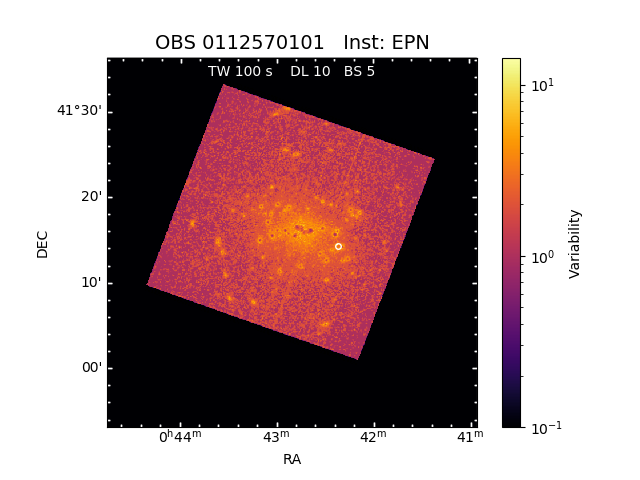

Text(0.5, 0.95, 'TW 100 s    DL 10   BS 5')

In [127]:
# Plotting the variability data
%matplotlib notebook
plt.subplot(111, projection=w)

im = plt.imshow(data, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)

ax = plt.gca()
ax.set_facecolor('k')
cbar = plt.colorbar(im)

# Plotting the sources
if len(src) != 0 :
    # Position of the sources
    for s in src:
        plt.plot(s['X'], s['Y'], 'wo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=1)
        

ra  = ax.coords[0]
dec = ax.coords[1]

ra.display_minor_ticks(True)
dec.display_minor_ticks(True)
ax.tick_params(axis='both', which='both', direction='in', color='w', width=1)

# Labels
plt.xlabel('RA', fontsize=10)
plt.ylabel('DEC', fontsize=10)
cbar.ax.set_ylabel('Variability', fontsize=10)

#plt.table(src)

# Title
plt.title('OBS {0}   Inst: {1}'.format(header['OBS_ID'], header['INSTRUME']), fontsize=14)
plt.text(0.5, 0.95, "TW {0} s    DL {1}   BS {2}".format(tw, dl, bs), color='white', fontsize=10, horizontalalignment='center', transform = ax.transAxes)

#### Test

In [128]:
src_PN

ID,INST,CCDNR,RAWX,RAWY,RAWR,X,Y,SKYR,RA,DEC,R
int16,str25,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,PN,5,41.56,191.07,4.0,32331.48,25474.69,256.0,10.5919,41.2398,12.8


In [103]:
src_PN_good

ID,INST,CCDNR,RAWX,RAWY,RAWR,X,Y,SKYR,RA,DEC,R
int16,str25,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,PN,5,41.56,191.07,4.0,32331.48,25474.69,256.0,10.5919,41.2398,12.8


# Test Affichage

In [2]:
path = '/home/monrillo/data/0401870301/'
obs  = '0401870301'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0

In [3]:
file0 = path + '{}_{}_{}_{}_PN/'.format(int(dl), int(tw), bs, gtr) + FileNames.VARIABILITY
file1 = path + '{}_{}_{}_{}_M1/'.format(int(dl), int(tw), bs, gtr) + FileNames.VARIABILITY
file2 = path + '{}_{}_{}_{}_M2/'.format(int(dl), int(tw), bs, gtr) + FileNames.VARIABILITY

In [4]:
# PN source list
hdulist = fits.open(file0)
src_PN = Table(hdulist[1].data)
hdulist.close()
# MOS 1 source list
hdulist = fits.open(file1)
src_M1 = Table(hdulist[1].data)
hdulist.close()
# MOS 2 source list
hdulist = fits.open(file2)
src_M2 = Table(hdulist[1].data)
hdulist.close()

# Checking correlation between lists

# Implementing correlation table
corr_table = Table(names=('ID_1', 'INST_1', 'RA_1', 'DEC_1', 'R_1','ID_2', 'INST_2', 'RA_2', 'DEC_2', 'R_2')\
                   , dtype=('i2', 'U25', 'f8', 'f8', 'f8','i2', 'U25', 'f8', 'f8', 'f8'))

# Checking correlation for the 3 EPIC
corr_table=check_correlation(src_PN, src_M1, corr_table)
corr_table=check_correlation(src_M1, src_M2, corr_table)
corr_table=check_correlation(src_PN, src_M2, corr_table)

# Sorting the table
corr_PN_M1 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M1'))]
corr_M1_M2 = corr_table[np.where((corr_table['INST_1']=='M1') & (corr_table['INST_2']=='M2'))]
corr_PN_M2 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M2'))]

# Checking for triple correlation
src_triple = []
if len(corr_PN_M1) !=0 and len(corr_M1_M2) !=0 and len(corr_PN_M2) !=0:
    src_triple = check_triple(corr_PN_M1, corr_M1_M2, corr_PN_M2)

<IPython.core.display.Javascript object>


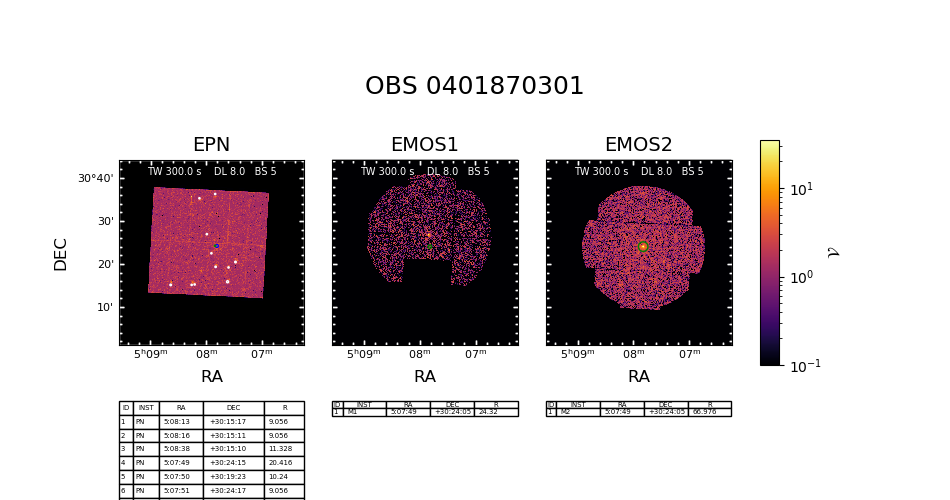

Text(0.5, 0.85, 'OBS 0401870301')

In [104]:
%matplotlib notebook
var_files = [file0, file1, file2]

# Starting loop on the different parameters
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9.5,5))
gs = gridspec.GridSpec(1, 3, wspace=0.15, hspace=0.6)

for i in range(len(var_files)) :

    hdulist = fits.open(var_files[i])

    data   = hdulist[0].data
    src    = hdulist[1].data
    header = hdulist[0].header

    hdulist.close()

    # Obtaining the WCS transformation parameters
    header.rename_keyword('RADECSYS', 'RADESYS')
    w = wcs.WCS(header)

    w.wcs.crpix = [header['REFXCRPX'], header['REFYCRPX']]
    w.wcs.cdelt = [header['REFXCDLT'], header['REFYCDLT']]
    w.wcs.crval = [header['REFXCRVL'], header['REFYCRVL']]
    w.wcs.ctype = [header['REFXCTYP'], header['REFYCTYP']]

    # Image limit
    dlim = [header['REFXLMIN'], header['REFXLMAX'], header['REFYLMIN'], header['REFYLMAX']]
        
    # Limite maximale de l'échelle des couleurs pour la normalisation par logarithme
    maximum_value = max([max(tmp) for tmp in data])

    # Plotting the variability data
    plt.subplot(gs[i], projection=w)
    ax = plt.gca()
    
    if i == 0:
        im = plt.imshow(data, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)
    else:
        im = plt.imshow(data*4, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)

    # Plotting the sources
    if len(src) != 0 :
        src_ap = correl_flag(src, corr_table, src_triple)
        for s in src_ap:
            if s['correl']=='':
                circ = Circle((s['X'],s['Y']), s['SKYR'],color="none", ec='white')
                ax.add_patch(circ)
                                    
            elif s['correl']!='' and s['correl']!='Triple':
                circ = Circle((s['X'],s['Y']), s['SKYR'],color="none", ec='blue')
                ax.add_patch(circ)
                                    
            elif s['correl']=='Triple':
                circ = Circle((s['X'],s['Y']), s['SKYR'],color="none", ec='green')
                ax.add_patch(circ)
        
                    
    plt.text(0.5, 0.92, "TW {0} s    DL {1}   BS {2}".format(header['TW'], header['DL'], header['BS']),\
                color='white', fontsize=7, horizontalalignment='center', transform = ax.transAxes)
    
    plt.title('{0}'.format(header['INSTRUME']), fontsize=14)
    
    src1=Table(src)
    c = SkyCoord(src1['RA'],src1['DEC'], frame='fk5', unit='deg')
    dat=src1['ID', 'INST', 'R']
    rahmsstr = Column(name='RA', data=c.ra.to_string(u.hour, sep=':', precision=0))
    decdmsstr = Column(name='DEC', data=c.dec.to_string(u.degree, alwayssign=True, sep=':', precision=0))
    dat.add_columns([rahmsstr,decdmsstr],indexes=[2,2])
    l=0.08*len(dat)
    src_table = plt.table(cellText=dat, colLabels=dat.colnames, colLoc='center',\
                          loc='top', cellLoc='left', bbox=[0.0,-(0.3+l),1,l])
    src_table.auto_set_column_width(col=list(range(len(dat))))
    src_table.auto_set_font_size(False)
    src_table.set_fontsize(5)
    #src_table.scale(1,3)

    ra  = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA', fontsize=12)
    dec.set_axislabel('DEC', fontsize=12)
        
    if i != 0 :
        dec.set_ticklabel_visible(False)

    #ax.add_patch(circ)
    ra.display_minor_ticks(True)
    dec.display_minor_ticks(True)
    ax.tick_params(axis='both', which='both', direction='in', color='w', width=1, labelsize=8)
    ax.set_facecolor('k')
    plt.show()


fig.subplots_adjust(right=0.77)
cbar_ax = fig.add_axes([0.8, 0.27, 0.02, 0.45])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\mathcal{V}$', fontsize=12)
fig.suptitle('OBS {0}'.format(header['OBS_ID']), x=0.5, y = 0.85, fontsize=18)

In [92]:
dat.colnames

['ID', 'INST', 'RA', 'DEC', 'R']

In [64]:
dat=np.concatenate(src1['ID'],src1['INST'],c.ra.to_string(u.hour),c.dec.to_string(u.degree, alwayssign=True),src1['R'])

TypeError: concatenate() takes from 1 to 3 positional arguments but 5 were given

In [81]:
str(c.dec.to_string(u.degree, alwayssign=True))

"['+30d24m05.4s']"

In [79]:
str(c.ra.to_string(u.hour))

"['5h07m49.44s']"